In [1]:
%matplotlib inline

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import histlite as hl
import csky as cy
import os

import matplotlib as mpl
from matplotlib.lines import Line2D
mpl.style.use('/home/apizzuto/Nova/python3/scripts/novae_plots_nb.mplstyle')
#palette = sns.color_palette('Dark2')
palette = sns.color_palette('Paired')

In [3]:
timer = cy.timing.Timer()
time = timer.time

## Begin with GFU (offline processing, v02_p05)
If the file doesn't exist, you need to run the script `time_integrated.py`

In [6]:
sinDecs = np.r_[-0.95:0.95:20j]
inj_gamma = [2.0, 2.5, 3.0]

if os.path.exists('/data/user/apizzuto/fast_response_skylab/offline_vs_online_gfu/dump/gfu_offline_sens_100tev.pkl'):
    with open('../dump/gfu_offline_sens_100tev.pkl', 'rb') as f:
        all_gamma_results = pickle.load(f)
else:
    print("TRIALS DON'T EXIST, GO RUN THE SCRIPT")

In [7]:
def conv_ref_en(fl, e1, e0, gamma):
    return np.asarray(fl) * (e1/e0)**(2.-gamma)

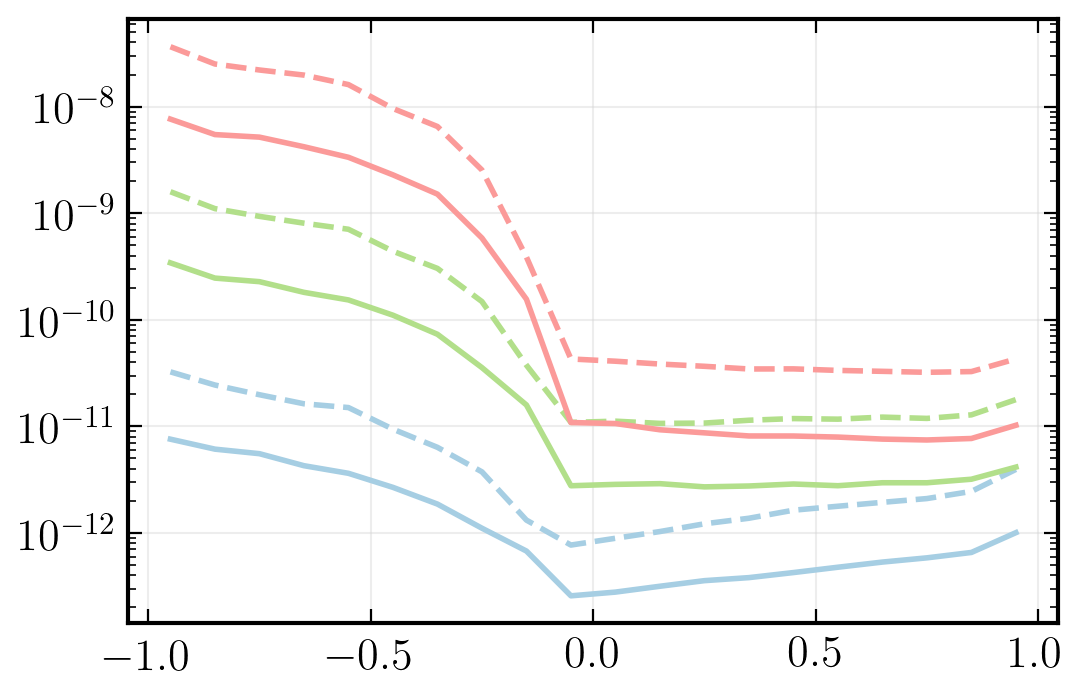

In [8]:
fig = plt.figure(dpi=200)
for ii, gamma in enumerate(inj_gamma):
    one_tev_sens = conv_ref_en(all_gamma_results[gamma]['sens_e2dnde'], 1., 100., gamma)
    one_tev_disc = conv_ref_en(all_gamma_results[gamma]['disc_e2dnde'], 1., 100., gamma)
    plt.plot(all_gamma_results[gamma]['sindec'], one_tev_sens,
            color=palette[2*ii], lw=2., ls='-')
    plt.plot(all_gamma_results[gamma]['sindec'], one_tev_disc,
            color=palette[2*ii], lw=2., ls='--')
    
plt.yscale('log')

## GFUOnline now
If file doesn't exist, run `time_integrated.py`

In [9]:
sinDecs = np.r_[-0.95:0.95:20j]
inj_gamma = [2.0, 2.5, 3.0]

if os.path.exists('/data/user/apizzuto/fast_response_skylab/offline_vs_online_gfu/dump/gfu_online_sens_100tev.pkl'):
    with open('../dump/gfu_online_sens_100tev.pkl', 'rb') as f:
        all_gamma_results_online = pickle.load(f)
else:
    print("NO TRIALS. RUN THE SCRIPT")

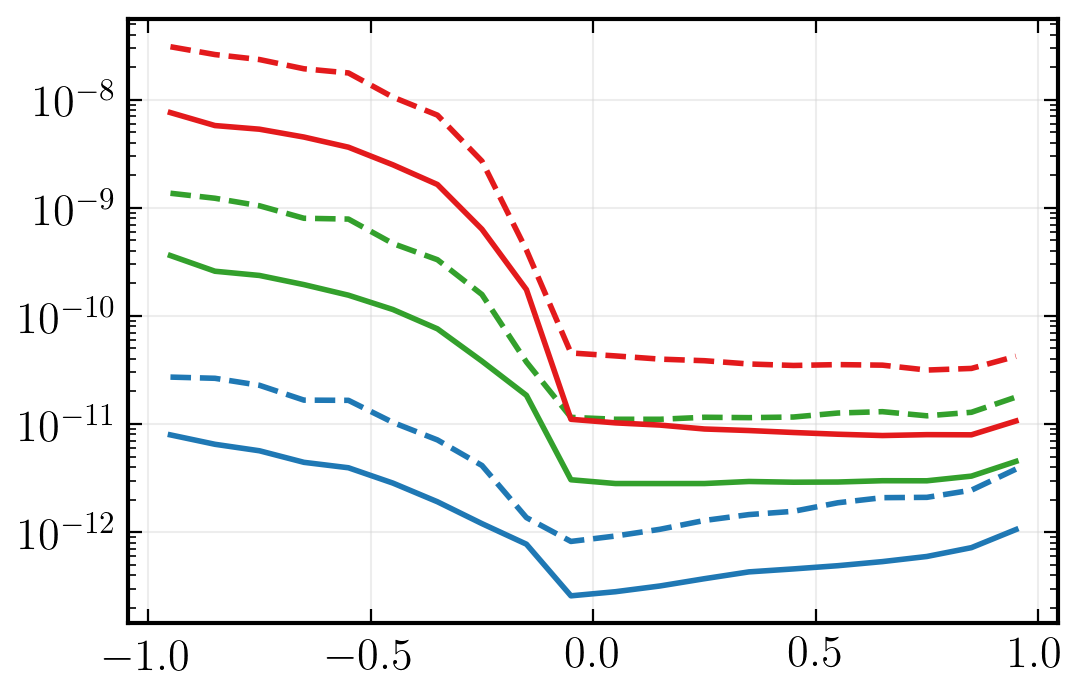

In [10]:
fig = plt.figure(dpi=200)
for ii, gamma in enumerate(inj_gamma):
    one_tev_sens = conv_ref_en(all_gamma_results_online[gamma]['sens_e2dnde'], 1., 100., gamma)
    one_tev_disc = conv_ref_en(all_gamma_results_online[gamma]['disc_e2dnde'], 1., 100., gamma)
    plt.plot(all_gamma_results_online[gamma]['sindec'], one_tev_sens,
            color=palette[2*ii+1], lw=2., ls='-')
    plt.plot(all_gamma_results_online[gamma]['sindec'], one_tev_disc,
            color=palette[2*ii+1], lw=2., ls='--')
    
plt.yscale('log')

## Now, compare . . . 

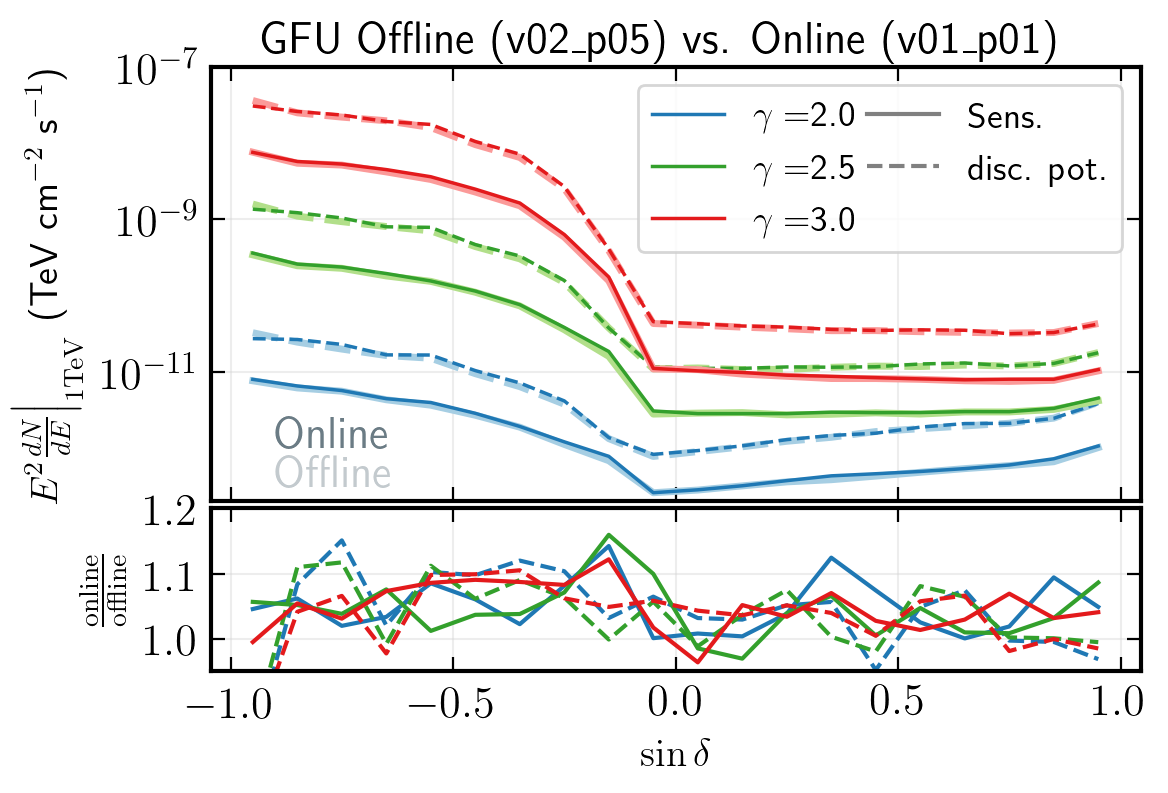

In [11]:
fig = plt.figure(dpi=200)
spec = mpl.gridspec.GridSpec(ncols=1, nrows=2,
                         height_ratios=[4, 1.5])
ax1 = fig.add_subplot(spec[1])
ax0 = fig.add_subplot(spec[0], sharex=ax1)
spec.update(wspace=0.025, hspace=0.025)
fig.set_facecolor('w')

for ii, gamma in enumerate(inj_gamma):
    one_tev_sens = conv_ref_en(all_gamma_results[gamma]['sens_e2dnde'], 1., 100., gamma)
    one_tev_disc = conv_ref_en(all_gamma_results[gamma]['disc_e2dnde'], 1., 100., gamma)
    ax0.plot(all_gamma_results[gamma]['sindec'], one_tev_sens,
            color=palette[2*ii], lw=2.5, ls='-')
    ax0.plot(all_gamma_results[gamma]['sindec'], one_tev_disc,
            color=palette[2*ii], lw=2.5, ls='--')
    
    one_tev_sens_online = conv_ref_en(all_gamma_results_online[gamma]['sens_e2dnde'], 1., 100., gamma)
    one_tev_disc_online = conv_ref_en(all_gamma_results_online[gamma]['disc_e2dnde'], 1., 100., gamma)
    ax0.plot(all_gamma_results_online[gamma]['sindec'], one_tev_sens_online,
            color=palette[2*ii+1], lw=1.25, ls='-', label=r'$\gamma=$' +f'{gamma}')
    ax0.plot(all_gamma_results_online[gamma]['sindec'], one_tev_disc_online,
            color=palette[2*ii+1], lw=1.25, ls='--')
    
    ax1.plot(all_gamma_results_online[gamma]['sindec'], one_tev_sens_online / one_tev_sens,
            color=palette[2*ii+1], lw=1.5, ls='-')
    ax1.plot(all_gamma_results_online[gamma]['sindec'], one_tev_disc_online / one_tev_disc,
            color=palette[2*ii+1], lw=1.5, ls='--')
    
handles, labels = ax0.get_legend_handles_labels()
patch = Line2D([0], [0], color='grey', lw=1.5, linestyle='-', label='Sens.')
handles.append(patch) 
patch = Line2D([0], [0], color='grey', lw=1.5, linestyle='--', label='disc. pot.')
handles.append(patch) 
    
ax0.legend(loc=1, frameon=True, ncol=2, handles=handles, fontsize=13, columnspacing=0.3)
ax0.set_yscale('log')
ax0.set_ylim(2e-13, 1e-7)
ax0.text(-0.9, 1e-12, 'Online', color=sns.xkcd_rgb['battleship grey'])
ax0.text(-0.9, 3e-13, 'Offline', color=sns.xkcd_rgb['battleship grey'], alpha=0.4)
ax1.set_ylim(0.95, 1.2)
plt.setp(ax0.get_xticklabels(), visible=False)
ax0.set_ylabel(r'$E^2\frac{dN}{dE}\bigg|_{\mathrm{1 TeV}}$ (TeV cm$^{-2}$ s$^{-1}$)', fontsize=14)
ax1.set_xlabel(r'$\sin \delta$', fontsize=14)
ax1.set_ylabel(r'$\frac{\mathrm{online}}{\mathrm{offline}}$', fontsize=14)
fig.suptitle("GFU Offline (v02\_p05) vs. Online (v01\_p01)", fontsize=16, y=0.94)
#plt.tight_layout()
for stype in ['pdf', 'png']:
    plt.savefig(f'../dump/time_integrated_online_vs_offline_comparison.{stype}', dpi=200,
               bbox_inches='tight')
plt.show()